In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils
directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "regression_paths", "nyc-rolling-sales-_dataset_path")

Extracting : 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


In [2]:
df = pd.read_csv('nyc-rolling-sales.csv')
print(df.head())
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
test = df[df['SALE PRICE'].isna()]
df = df[~df['SALE PRICE'].isna()]
print(df.shape)
df = df[(df['SALE PRICE'] > 1000)]
print(df.shape)
print(df.columns)
print(df.shape)
print(df.info())
print(df.isna().sum())
print(df.describe())
del df['Unnamed: 0']
del df['EASE-MENT']
df = df.drop_duplicates(df.columns, keep='last')

sum(df.duplicated(df.columns))

   Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
0    6                                  C2            153 AVENUE B  ...   
1   26                                  C7   234 EAST 4TH   STREET  ...   
2   39                                  C7   197 EAST 3RD  

0

In [3]:
df['YEAR BUILT'] = df['YEAR BUILT'].replace(0, 1915)
df['YEAR BUILT'].value_counts()
print(df.shape)
print(df['SALE DATE'].dtype)
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
print(df['SALE DATE'].dtype)
df.sort_values(by=['SALE DATE'], inplace=True, ascending=True, ignore_index=True)
df.head()
df['Sale Day'] = df['SALE DATE'].dt.day
df['Sale Year'] = df['SALE DATE'].dt.year
df['Sale Month'] = df['SALE DATE'].dt.month

(58470, 20)
object
datetime64[ns]


In [4]:
df.head()
print(df['Sale Year'].value_counts())
del df['SALE DATE']
df.head()
print(df['TAX CLASS AT TIME OF SALE'].dtype)
print(df['TAX CLASS AT PRESENT'].dtype)
print(df['LAND SQUARE FEET'].dtype)
print(df['GROSS SQUARE FEET'].dtype)
print(df['SALE PRICE'].dtype)
print(df['BOROUGH'].dtype)

2017    38662
2016    19808
Name: Sale Year, dtype: int64
int64
object
object
object
float64
int64


In [5]:
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [6]:
print(df['TAX CLASS AT TIME OF SALE'].dtype)
print(df['TAX CLASS AT PRESENT'].dtype)
print(df['LAND SQUARE FEET'].dtype)
print(df['GROSS SQUARE FEET'].dtype)
print(df['SALE PRICE'].dtype)
print(df['BOROUGH'].dtype)
print(df['NEIGHBORHOOD'].dtype)
print(df['BUILDING CLASS CATEGORY'].dtype)
print(df['LOT'].dtype)
print(df['BUILDING CLASS AT PRESENT'].dtype)
print(df['TOTAL UNITS'].dtype)
print(df['ZIP CODE'].dtype)
print(df['YEAR BUILT'].dtype)
print(df['BUILDING CLASS AT TIME OF SALE'].dtype)

int64
object
float64
float64
float64
int64
object
object
int64
object
int64
int64
int64
object


In [7]:
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET'], dtype='object')

In [8]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())
df['LAND SQUARE FEET'].replace(to_replace = 0, value = df['LAND SQUARE FEET'].median(), inplace=True)
df['LAND SQUARE FEET'].value_counts()
df['GROSS SQUARE FEET'].replace(to_replace = 0, value = df['GROSS SQUARE FEET'].median(), inplace=True)
df['GROSS SQUARE FEET'].value_counts()

3379.949293     21532
2550.000000      8563
1800.000000       244
1600.000000       235
1440.000000       233
                ...  
4895.000000         1
3457.000000         1
45624.000000        1
5404.000000         1
593.000000          1
Name: GROSS SQUARE FEET, Length: 4455, dtype: int64

In [9]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [10]:
def remove_outlier(df, col_name):
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
  return df_out

df = remove_outlier(df, 'SALE PRICE')

print(df.shape)

(52252, 22)


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df.NEIGHBORHOOD) 
df.NEIGHBORHOOD = le.transform(df.NEIGHBORHOOD)
le.fit(df['ZIP CODE']) 
df['ZIP CODE'] = le.transform(df['ZIP CODE'])
le.fit(df['ADDRESS']) 
df['ADDRESS'] = le.transform(df['ADDRESS'])
le.fit(df['BOROUGH']) 
df['BOROUGH'] = le.transform(df['BOROUGH'])
le.fit(df['BUILDING CLASS CATEGORY']) 
df['BUILDING CLASS CATEGORY'] = le.transform(df['BUILDING CLASS CATEGORY'])
le.fit(df['BUILDING CLASS AT PRESENT']) 
df['BUILDING CLASS AT PRESENT'] = le.transform(df['BUILDING CLASS AT PRESENT'])
le.fit(df['BUILDING CLASS AT TIME OF SALE']) 
df['BUILDING CLASS AT TIME OF SALE'] = le.transform(df['BUILDING CLASS AT TIME OF SALE'])
le.fit(df['TAX CLASS AT PRESENT']) 
df['TAX CLASS AT PRESENT'] = le.transform(df['TAX CLASS AT PRESENT'])
le.fit(df['TAX CLASS AT TIME OF SALE']) 
df['TAX CLASS AT TIME OF SALE'] = le.transform(df['TAX CLASS AT TIME OF SALE'])

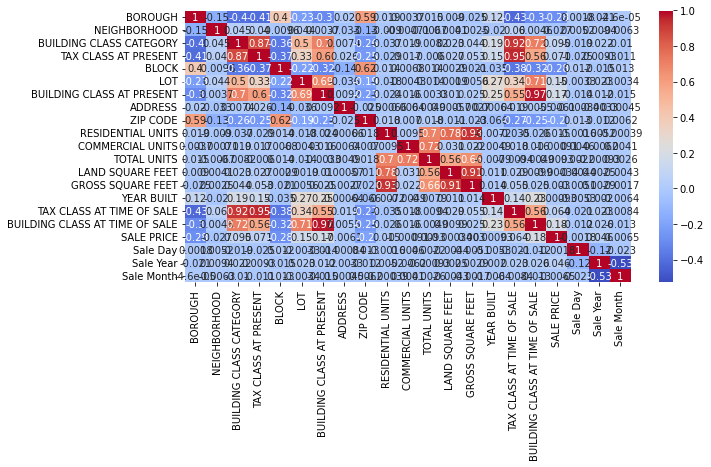

In [12]:
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),annot = True , cmap = 'coolwarm' );

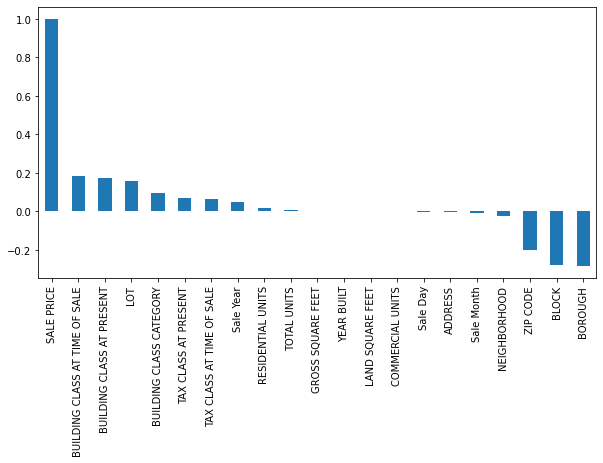

In [13]:
corr_mat = df.corr()
plt.figure(figsize = (10,5))
corr_mat['SALE PRICE'].sort_values(ascending = False).plot(kind = 'bar');

In [14]:
df.corr()['SALE PRICE'].sort_values(ascending=False).abs()

SALE PRICE                        1.000000
BUILDING CLASS AT TIME OF SALE    0.184661
BUILDING CLASS AT PRESENT         0.173937
LOT                               0.154969
BUILDING CLASS CATEGORY           0.094577
TAX CLASS AT PRESENT              0.071021
TAX CLASS AT TIME OF SALE         0.064074
Sale Year                         0.046246
RESIDENTIAL UNITS                 0.015107
TOTAL UNITS                       0.009333
GROSS SQUARE FEET                 0.003048
YEAR BUILT                        0.000932
LAND SQUARE FEET                  0.000337
COMMERCIAL UNITS                  0.000910
Sale Day                          0.001798
ADDRESS                           0.006140
Sale Month                        0.006511
NEIGHBORHOOD                      0.026850
ZIP CODE                          0.200177
BLOCK                             0.277641
BOROUGH                           0.283852
Name: SALE PRICE, dtype: float64

In [15]:
del df['NEIGHBORHOOD']
del df['ADDRESS']
del df['Sale Month']
del df['YEAR BUILT']
del df['Sale Year']
del df['Sale Day']
del df['COMMERCIAL UNITS']

In [16]:
del df['APARTMENT NUMBER']

In [17]:
df[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,23314
0,0,15355
2,2,9546
3,3,2635
4,4,628
...,...,...
39,72,1
40,75,1
42,84,1
43,86,1


In [18]:
df = df[(df['TOTAL UNITS'] > 0) & (df['TOTAL UNITS'] != 2261)]
df['TOTAL UNITS'].value_counts()

1       23314
2        9546
3        2635
4         628
6         320
        ...  
1866        1
324         1
136         1
128         1
68          1
Name: TOTAL UNITS, Length: 66, dtype: int64

In [19]:
df.shape

(36896, 14)

In [20]:
df.shape

(36896, 14)

In [21]:
print(df.columns)

Index(['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK',
       'LOT', 'BUILDING CLASS AT PRESENT', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE'],
      dtype='object')


In [22]:
cat_col = ['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']

df = pd.get_dummies(data=df, drop_first=True, columns = cat_col)

print(df)

       BLOCK   LOT  ZIP CODE  RESIDENTIAL UNITS  TOTAL UNITS  \
0        858  1032        14                  0            1   
1       5868  1025       112                  1            1   
2       2367  1034       103                  0            1   
8       9470    39       164                  2            2   
12      3585  1127        50                  1            1   
...      ...   ...       ...                ...          ...   
58460   5589    56       110                  3            3   
58462  16033    21       179                  2            2   
58465   2752  1107       103                  1            1   
58468   4612    50       104                  4            4   
58469   5066  2018       132                  1            1   

       LAND SQUARE FEET  GROSS SQUARE FEET  SALE PRICE  BOROUGH_1  BOROUGH_2  \
0           3621.612063        3379.949293     25000.0          0          0   
1           3621.612063        2550.000000    410000.0          0      

In [23]:
Y_fdf = df['SALE PRICE']
X_fdf = df.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape
from sklearn.model_selection import train_test_split 
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.05 , random_state = 1)
X_train.shape , Y_train.shape

((35051, 274), (35051,))

In [24]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

In [25]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred_lr = lr.predict(X_test)

In [26]:
y_true, Y_pred = np.array(Y_test), np.array(Y_pred_lr)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100 #mean absolute percntage error
print(mape)

130.93132220889925


In [27]:
from sklearn.metrics import mean_absolute_error as mae
error = mae(y_true,Y_pred)
print(error)

259486.4216969859


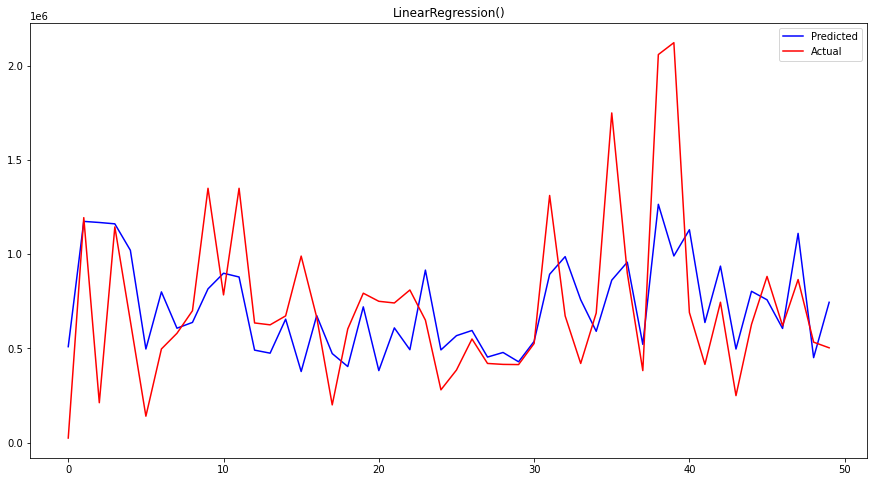

In [28]:
plt.figure(figsize=(15, 8))
y_true, y_pred = np.array(Y_test), np.array(Y_pred_lr)
plt.plot(y_pred[0:50], label='Predicted', color="blue")
plt.plot(y_true[0:50], label='Actual', color="red")
plt.title(lr)
plt.legend()

In [30]:
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures (degree = 2)
#x_quad = quad.fit_transform(X_fdf)
##X_hat = pd.DataFrame(x_quad)
#print(X_hat.shape)
X_train,X_test,y_train,y_test = train_test_split(X_fdf,Y_fdf,test_size=0.05, random_state = 0)
rf = RandomForestRegressor(n_estimators=250, random_state=0).fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
score = r2_score(y_test,y_pred_rf)
error = mae(y_test,y_pred_rf)
mse = mean_squared_error(y_test,y_pred_rf)
y_true, y_pred = np.array(y_test), np.array(y_pred_rf)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #mean absolute percntage error
mdape = np.median((np.abs((y_true - y_pred)/ y_true))) * 100 #median absolute percntage error
print(score)
print(error)
print(mse)
print(mape)
print(mdape)

0.5682121493928487
187366.19214988808
80514425576.1245
94.03859296951
18.538934274509796


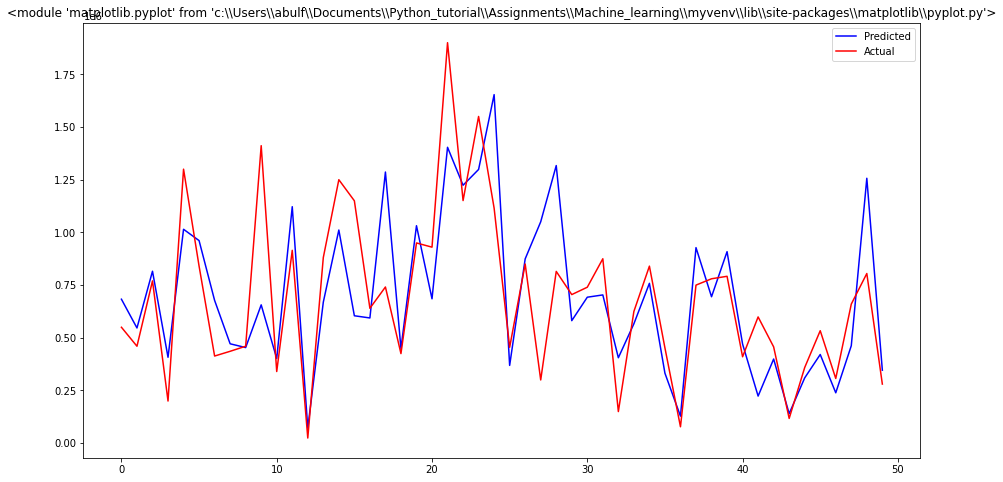

In [31]:
 plt.figure(figsize=(15, 8))
 plt.plot(y_pred[0:50], label='Predicted', color="blue")
 plt.plot(y_true[0:50], label='Actual', color="red")
 plt.title(plt)
 plt.legend()

In [32]:
print(y_pred)
print(y_true)

[683079.8        546593.93666667 815760.38       ... 348471.84885714
 804653.328      472905.00266667]
[550000. 460000. 770000. ... 300000. 848000. 304000.]


In [33]:
print(df.describe())

              BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  36896.000000  36896.000000  36896.000000       36896.000000   
mean    4926.560576    438.362478    102.495203           1.710077   
std     3736.906292    700.855154     47.530219          11.358579   
min        1.000000      1.000000      0.000000           0.000000   
25%     1763.000000     27.000000     56.000000           1.000000   
50%     4307.000000     59.000000    108.000000           1.000000   
75%     7040.000000   1014.000000    141.000000           2.000000   
max    16319.000000   9024.000000    181.000000        1844.000000   

        TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    SALE PRICE  \
count  36896.000000      3.689600e+04       3.689600e+04  3.689600e+04   
mean       1.789625      3.498417e+03       2.739390e+03  7.315880e+05   
std       11.499591      2.495103e+04       2.126606e+04  4.324611e+05   
min        1.000000      2.000000e+02       1.200000e+02  1.162000e+03   

In [34]:
y_pred = y_pred/1000
y_true = y_true/1000
print(y_pred)
print(y_true)

[683.0798     546.59393667 815.76038    ... 348.47184886 804.653328
 472.90500267]
[550. 460. 770. ... 300. 848. 304.]


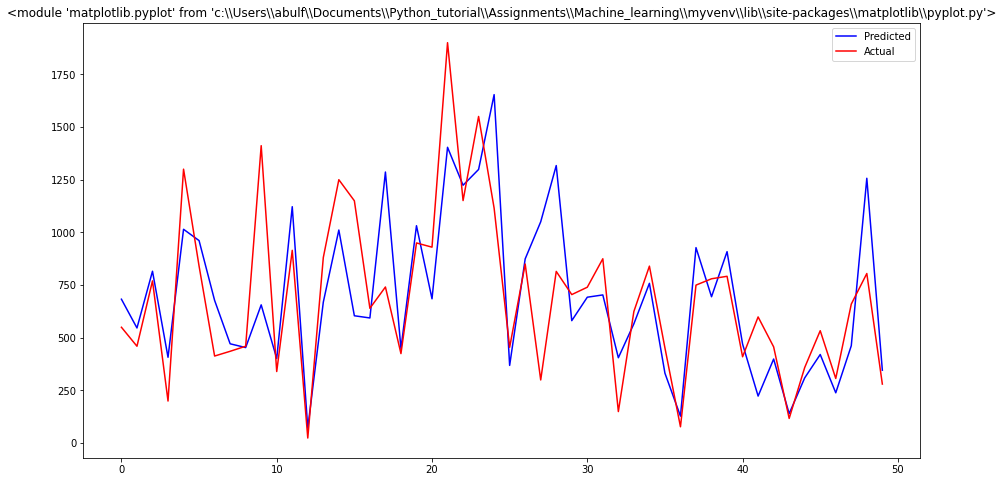

In [35]:
 plt.figure(figsize=(15, 8))
 plt.plot(y_pred[0:50], label='Predicted', color="blue")
 plt.plot(y_true[0:50], label='Actual', color="red")
 plt.title(plt)
 plt.legend()

In [36]:
#without using one hot encoder decreases mae by 1000
